In [1]:
from qlty import cleanup
from qlty.qlty2D import NCYXQuilt

import torch
import matplotlib.pyplot as plt

In [2]:
x = torch.linspace(-1,1,256)
X,Y = torch.meshgrid(x,x)

# make data
sample_data1 = torch.exp( -torch.cos( (X*X-Y*Y+X*Y)*50 ) )
sample_data1 = sample_data1 / torch.max(sample_data1)
sample_data2 = torch.exp( -torch.sin( (X*X+Y*Y-X*Y)*50 ) )
sample_data2 = sample_data2 / torch.max(sample_data2)

#concatenate
sample_data = torch.concat([sample_data1.unsqueeze(0), sample_data2.unsqueeze(0)])

# make sparse labels
sel = sample_data > 0.5
labels = torch.ones(sample_data.shape).type(torch.LongTensor)
labels[~sel] = 0
labels[:, :100, :] = -1
labels[:, 180:, :] = -1
labels[:, :, :50] = -1
labels[:, :, -50:] = -1

sample_data = sample_data.unsqueeze(1)
print(sample_data.shape)


torch.Size([2, 1, 256, 256])


/home/pzwart/anaconda3/envs/dlsia-new/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


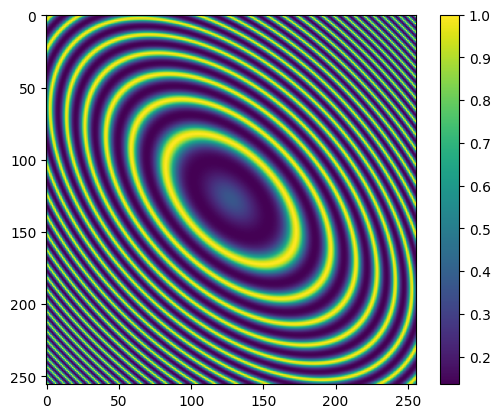

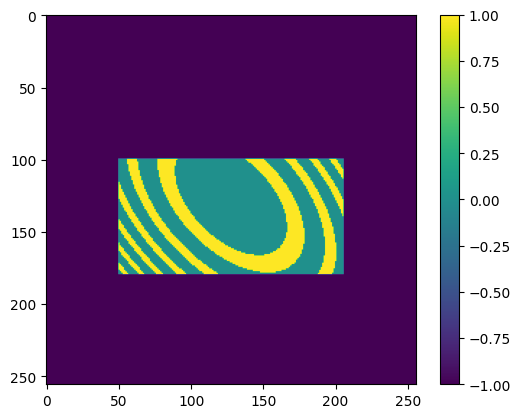

In [3]:
plt.imshow(sample_data.numpy()[1,0])
plt.colorbar()
plt.show()

plt.imshow(labels.numpy()[1])
plt.colorbar()
plt.show()

Now use qlty to get an object that can chop the tensors up

In [4]:
# this object handles unstitching and stitching
qlty_object = NCYXQuilt(X=sample_data.shape[-1], 
                        Y=sample_data.shape[-2],
                        window = (50,50),
                        step = (30,30),
                        border = (3,3))                        

Chop it up and stitch back together

In [5]:
patches = qlty_object.unstitch(sample_data)
print("Patches:", patches.shape)

stitched,weights= qlty_object.stitch(patches)
print("Stitched:", stitched.shape, "weights:", weights.shape)
# weights: counts how many contributor each pixel has due to partial overlap

Patches: torch.Size([128, 1, 50, 50])
Stitched: torch.Size([2, 1, 256, 256]) weights: torch.Size([256, 256])


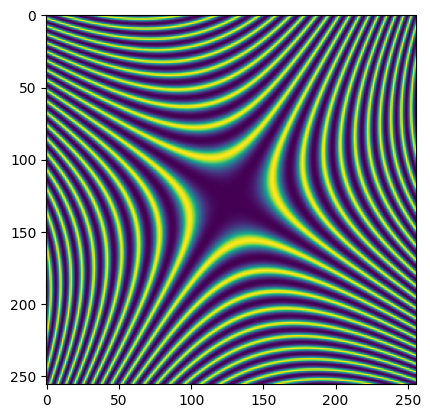

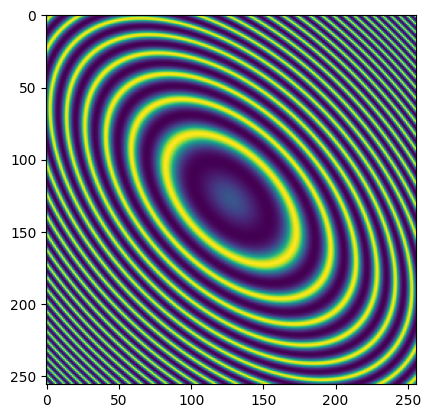

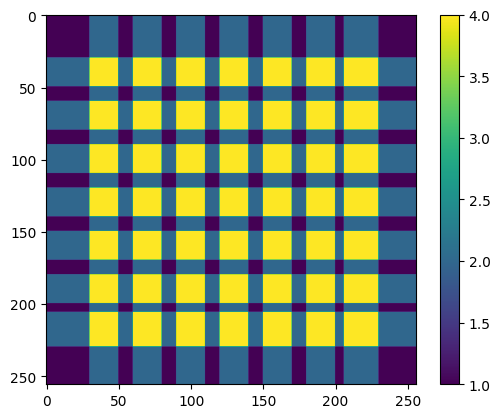

In [6]:
plt.imshow(stitched.numpy()[0,0])
plt.show()
plt.imshow(stitched.numpy()[1,0])
plt.show()
plt.imshow(weights.numpy())
plt.colorbar()
plt.show()


Now lets take the data and only get those patches that we need

In [7]:
imgs, lbls = qlty_object.unstitch_data_pair(sample_data, labels)
print(imgs.shape, lbls.shape)

torch.Size([128, 1, 50, 50]) torch.Size([128, 50, 50])


Lets only keep what we need, i.e. images where we actually have labels. We also print a 

In [8]:
border_tensor = qlty_object.border_tensor()

clean_imgs, clean_labels, is_empty_image = cleanup.weed_sparse_classification_training_pairs_2D(imgs,
                                                                  lbls, 
                                                                  missing_label=-1, 
                                                                  border_tensor=border_tensor)

In [9]:
print(clean_imgs.shape)
print(clean_labels.shape)
print(is_empty_image)

torch.Size([48, 1, 50, 50])
torch.Size([48, 50, 50])
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False,  True,  True, False, False, False, False, False, False,  True,
         True, False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False,  True,  True, False,
        False, False, False, False, False,  True,  True, False, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         Tr

The stitch method doesn't really care about the number of channels

In [10]:
some_result_from_ml_inference = torch.rand( (imgs.shape[0], 11, imgs.shape[-2], imgs.shape[-1]) )
my_stitched_map, _ = qlty_object.stitch(some_result_from_ml_inference)
print(my_stitched_map.shape)

torch.Size([2, 11, 256, 256])


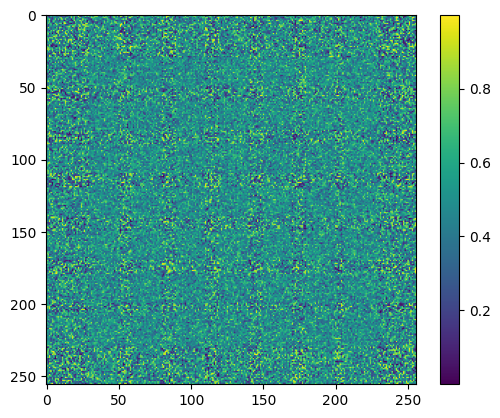

In [11]:
plt.imshow(my_stitched_map.numpy()[0,5])
plt.colorbar()
plt.show()

All done.